# Diabetes Prediction Using Ensembling of Different Machine Learning Classifiers 
##The python Library we used are :

<ul>
<li>Numpy</li>
<li>Pandas</li>
<li>scipy</li>
<li>Seaborn</li>
<li>Sklearn</li>
<li>xgboost</li>
</ul>


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,matthews_corrcoef
import numpy as np
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier, GradientBoostingClassifier,VotingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from scipy import stats
from scipy.stats import uniform, randint
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score,roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy import interp
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from keras.utils import to_categorical
from sklearn.naive_bayes import GaussianNB
import warnings 
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation, Dense, Dropout, BatchNormalization, Input
from keras.models import Model
from keras.optimizers import Adam

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
# thsis function removes the outliers.
def Outlier_Removal_IQR (data):
  for col in data.columns:                               
    C1 = data[col].quantile(0.25)
    C3 = data[col].quantile(0.75)
    IQR = C3-C1                                         
    LB = (C1 - 1.5 * IQR)                                   #find lower boundary
    UB = (C3 + 1.5 * IQR)                                   #find upper boundary
    data = data[data[col]<UB]                #drop greater than upper limit
    data = data[data[col]>LB]                #drop smaller than lower limit

  return data
  #this  function is for algorithm based feature selection 
def feature_Selection(data, selector, n_feature):
    if selector=='SelectKbest':
        X_train= data.iloc[:,:8]
        Y_train=data.iloc[:,8:]
        select=SelectKBest(chi2, k=n_feature) 
        select.fit_transform(X_train, Y_train)
        cols = select.get_support(indices=True)
        X_train_selected = X_train.iloc[:,cols]
        # print(X_train_selected.columns)
        return X_train_selected,Y_train
    if selector  == 'None':
        return data.iloc[:,:8].values, data.iloc[:,8:].values            
    if selector=='PCA':                                                  
        X_Data= data.iloc[:,:8].values
        pca = PCA(n_components=n_feature)                             
        X_Data = pca.fit_transform(X_Data)
        return X_Data , data.iloc[:,8:].values
    if selector  == 'None':
        return data.iloc[:,:8].values, data.iloc[:,8:].values           
    if selector =='corr':                                                   
        if n_feature ==6:
            data.drop(['BloodPressure','Age'],axis=1,inplace=True)
            return data.iloc[:,:6].values, data.iloc[:,6:].values

In [7]:
data=pd.read_csv("/content/drive/MyDrive/MLBA Project/diabetes.csv")
data.head()
# data.describe()
# data.shape

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<h2> Data Competency Assessment</h2>
<ul>
<li>Checking Null values.</li>
<li>Finding correlation between the different features.</li>
<li>Finding Best features for the best model performance.</li>
</ul>

Is there any Null value?  False


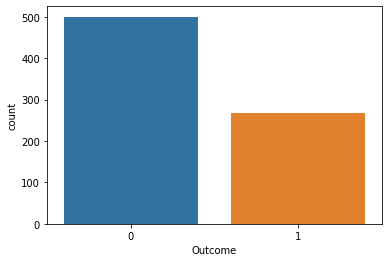

In [8]:
# =========================== Finding null value =======================================
print("Is there any Null value? ",data.isnull().any().any())
# =========================== plotting class distribution =======================================
sns.countplot(data['Outcome'])

<h3> Observations from the above Countplot.</h3>
<ul>
<li> There is the problem of class imbalancy (using oversampling techniques to handel this problem). </li>
</ul>

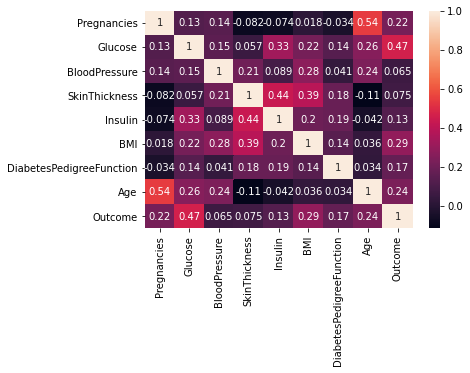

In [9]:
# =========================== Cheacking Corrilation Between the different Features =======================================
# sns.heatmap(data,annot=True, fmt="g", cmap='viridis')
corr = data.corr()
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,annot=True)

### Preprocessing Selection
---
Process Selector | Preprocessing | 
---|---|
P|Filling Missing Value|
Q|Outlier Removal|
R|Standardization|
S|Feature Selection|


---
Process Selector | Preprocessing | 
---|---|
P|Filling Missing Value|

In [10]:
data.fillna(data.mean())
print()
  

---
Process Selector | Preprocessing | 
---|---|
Q|Outlier Removal|

In [11]:
print('Shape Before Outlier Removal: ' + str(data.shape))
data = Outlier_Removal_IQR  (data)

print('Shape After Outlier Removal: ' + str(data.shape))

Shape Before Outlier Removal: (768, 9)
Shape After Outlier Removal: (636, 9)


In [12]:
def replace_zero(data, col, target):
    
    mean_by_target = data.loc[data[col] != 0, [col, target]].groupby(target).mean()
    data.loc[(data[col] == 0)&(data[target] == 0), col] = mean_by_target.iloc[0][0]
    data.loc[(data[col] == 0)&(data[target] == 1), col] = mean_by_target.iloc[1][0]
for x in ['BloodPressure'	,'SkinThickness',	'Insulin',	'BMI',	'DiabetesPedigreeFunction']:  
    replace_zero(data, x, 'Outcome')   

---
Process Selector | Preprocessing | 
---|---|
R|Standardization|

In [13]:
# # =========================== Scaling data  =======================================
# scaler = StandardScaler()
# # data_train=data.drop(['Outcome'],axis=1)
# scaled_data=scaler.fit_transform(data.drop(['Outcome'],axis=1))
# X= pd.DataFrame(scaled_data, index=data.index, columns=list(data.columns)[:-1])
# Y=data['Outcome']
# print(X)

---
Process Selector | Preprocessing | 
---|---|
S|Feature Selection|

In [14]:
print('Shape Before feature selection: ' + str(data.shape))
X_train,Y_train = feature_Selection(data, selector='corr', n_feature=6)    
print('Shape After Feature Selection: ' + str(X_train.shape))

Shape Before feature selection: (636, 9)
Shape After Feature Selection: (636, 6)


In [15]:
# model creation using GridSearchCV
def model_creation (classifier, X_Train, Y_Train, tuned_parameters, verbose):
  clf = GridSearchCV(classifier, tuned_parameters,verbose=verbose, cv=5, scoring='roc_auc',n_jobs=-1)
  clf.fit(X_Train, Y_Train)
  return clf

In [16]:
# This function is used to calculate the different metrics
def metrics (y_true, y_pred, probas_):
  marks=n_dots*'-'
  print(marks)
  fpr, tpr, thresholds = roc_curve(y_true, probas_[:, 1])
  tprs.append(interp(mean_fpr, fpr, tpr))
  tprs[-1][0] = 0.0
  roc_auc = auc(fpr, tpr)
  print("classification report for current fold:\n")
  print(classification_report(y_true, y_pred))
  print("Area Under ROC (AUC) for the current fold: {}".format(roc_auc))
  print('Confusion Matrix for current fold: ')
  print(confusion_matrix(y_true, y_pred))
  print("Accuracy for Current Fold: {}".format(accuracy_score(y_true, y_pred)))
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  return  tn, fp, fn, tp, roc_auc, fpr, tpr
# It make avarages of all the lists and print them in a formatted manner
def average_scores(aucs,Accuracy,TP,TN,FP,FN): 
  print()
  n_dotsav=(n_dots-len('Average'))//2
  print('-'*n_dotsav+'Average'+'-'*n_dotsav)
  print("AUC (Avg.) is  %0.3f" %(np.mean(aucs)))
  print("Accuracy (Avg.) is  %0.3f" %(np.mean(Accuracy)))
  cm = [[int(np.mean(TP)), int(np.mean(FP))],[int(np.mean(FN))]]
  print ('Avg. CM is '+str(cm))
  cm = [[int(np.sum(TP)), int(np.sum(FP))],[int(np.sum(FN)), int(np.sum(TN))]]
  print ('Total for all folds CM is '+str(cm))
  re_auc=str(round(np.mean(aucs), 3))+'+/-'+str(round(np.std(aucs),3))
  all_clf_res.append(re_auc)

In [17]:
'''
Defining different models and tunning their hyperparameters using GridsearchCV.
It creates different models on best parameters and return the model to evaluate.

'''
def model_Ensemble(n_model, X_Train, Y_Train, X_Test, Y_Test, weight):
        
    parameters_rf = {'criterion': ['gini','entropy']}         

    mrf = model_creation (classifier = RandomForestClassifier(random_state=random_initializer),X_Train = X_Train,  Y_Train = Y_Train,
                      tuned_parameters = parameters_rf,
                      verbose=0) 
                                                                          
    n_neighbors = [1,7,9,11,13,15,21,23,25,27,29,31,33,35,41,43,45,47,49]
    leaf_size = [5,10,15,20,25,30,35,40,45,50]
    Distance = [1,2]
                                                                    
    parameters_knn = [ {'n_neighbors': n_neighbors, 'algorithm' : ['brute'],'p':Distance},{'n_neighbors': n_neighbors, 'algorithm' : ['ball_tree'],'leaf_size' : leaf_size,
                        'p':Distance},{'n_neighbors': n_neighbors, 'algorithm' : ['kd_tree'],'leaf_size' : leaf_size,'p':Distance}]
    parameters_dt = {'criterion': ['gini','entropy'],'splitter': ['best'],'min_samples_split':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],'min_samples_leaf': [1,2,3,4,5] }
    mdt =model_creation (classifier = DecisionTreeClassifier(random_state=random_initializer), X_Train = X_Train,   Y_Train = Y_Train, tuned_parameters = parameters_dt,verbose=0)  #create model with DecisionTree classifier with utility function 

    mknn = model_creation (classifier = KNeighborsClassifier(),X_Train = X_Train,Y_Train = Y_Train,tuned_parameters = parameters_knn,verbose=0)                         #create knn with  function     
    
    parameters_ab = { 'algorithm': ['SAMME','SAMME.R'],  'learning_rate':[0.1,0.5,1.0], 'n_estimators': [10,50,100,200]} # define parameters of adaboost

    mab =model_creation (classifier = AdaBoostClassifier(random_state=random_initializer), X_Train = X_Train, Y_Train = Y_Train,tuned_parameters =parameters_ab,verbose=0)
    
    parameters_nb = [{'var_smoothing': [1e-01,1e-02,1e-03,1e-04,1e-05,1e-06,1e-07,1e-08,1e-09, 1e-10, 1e-11, 1e-12]}]         # define parameters of Naive Bais

    mnb = model_creation (classifier = GaussianNB(), X_Train = X_Train, Y_Train = Y_Train,tuned_parameters = parameters_nb,verbose=0)
    parameters_xb = {      'min_child_weight': [1, 5, 10],'gamma': [0.5, 1, 1.5, 2, 5],'subsample': [0.5, 1.0],'colsample_bytree': [0.6, 0.8, 1.0],'max_depth': [3, 4, 5] }

        
    mxb =model_creation (classifier = xgb.XGBClassifier(objective = "binary:logistic", eval_metric = 'error',random_state=random_initializer), X_Train = X_Train, Y_Train = Y_Train,tuned_parameters = parameters_xb,verbose=0)
    
    

    models=[('knn', mknn), ('xb',mxb),('dt',mdt),('rf',mrf),('nb',mnb),('ab',mab)]
    if weight == 'accuracy':
        if n_model == 2:                                               
            model_index=[5,1]                                            
            model = VotingClassifier( [models[i] for i in model_index], voting='soft', weights=[accuracy_score(Y_Test, mab.predict(X_Test)),accuracy_score(Y_Test, mxb.predict(X_Test))])

            model.fit(X_Train,Y_Train)
            return model 
        if n_model == 3:                                               
            model_index=[0,1,2]                                              
            model = VotingClassifier( [models[i] for i in model_index] , voting='soft', weights=[accuracy_score(Y_Test, mknn.predict(X_Test)),accuracy_score(Y_Test, mb.predict(X_Test)), accuracy_score(Y_Test, mdt.predict(X_Test))])   

            model.fit(X_Train,Y_Train)
            return model
        if n_model == 4:    
            model_index=[5,1,2,3]                                              
            model = VotingClassifier( [models[i] for i in model_index] , voting='soft', weights=[accuracy_score(Y_Test, mab.predict(X_Test)),accuracy_score(Y_Test, mxb.predict(X_Test)),accuracy_score(Y_Test, mdt.predict(X_Test)),accuracy_score(Y_Test, mrf.predict(X_Test))])                                           #Using 6 best model we create ensembled model with soft voting    

            model.fit(X_Train,Y_Train)
            return model
        if n_model == 5:     
            model_index=[0,1,2,3,4]                                              
            model = VotingClassifier( [models[i] for i in model_index] , voting='soft',weights=[accuracy_score(Y_Test, mknn.predict(X_Test)), accuracy_score(Y_Test, mxb.predict(X_Test)),accuracy_score(Y_Test, mdt.predict(X_Test)),accuracy_score(Y_Test, mrf.predict(X_Test)), accuracy_score(Y_Test, mnb.predict(X_Test))])                                           #Using 6 best model we create ensembled model with soft voting    

            model.fit(X_Train,Y_Train)
            return model


    if weight == 'None':                                              
        if n_model == 2:
            model_index=[5,1]                                              
            model = VotingClassifier( [models[i] for i in model_index], voting='soft')
            model.fit(X_Train,Y_Train)
            return model 
            
        if n_model == 3:                                               

            model_index=[0,1,2]                                              
            model = VotingClassifier( [models[i] for i in model_index] , voting='soft')
            model.fit(X_Train,Y_Train)
            return model
        if n_model == 4:                                               

            model_index=[5,1,2,3]                                              
            model = VotingClassifier( [models[i] for i in model_index] , voting='soft') 
            model.fit(X_Train,Y_Train)
            return model
        if n_model == 5:                                               
            
            
            model_index=[0,1,2,3,4]                                              
            model = VotingClassifier( [models[i] for i in model_index] , voting='soft') 
            model.fit(X_Train,Y_Train)
            return model
        if n_model == 6:                                               
            
            
            model_index=[0,1,2,3,4,5]                                              
            model = VotingClassifier( [models[i] for i in model_index] , voting='soft') 
            model.fit(X_Train,Y_Train)
            return model


In [18]:
def Make_model_seq(activation,dropout_rate,init,learn_rate):

    neuron1,neuron2,neuron3,neuron4=64,16,64,64

    
    model = Sequential()
    np.random.seed(6)
    model.add(Dense(64, input_dim =6, kernel_initializer= init, activation= activation))
    model.add(Dense(16, input_dim = neuron1, kernel_initializer= init, activation= activation))
    model.add(Dense(64, input_dim = neuron2, kernel_initializer= init, activation= activation))
    model.add(Dense(64, input_dim = neuron3, kernel_initializer= init, activation= activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(2, activation='softmax'))
    
    optimizer = Adam(lr = learn_rate)               #optimizer of Neural network 
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) #compile model 
    #################################################################################################
    return model     


In [20]:

'''
Here all the ensamble model prepares for different 5 fold and all the accuracy metrics stores in there corresponding lists.
Here is the description of the different lists.
FP: False positives
TN: True Negatives
TP: True Positives
TN: True negatives
sn: sencetivity
sp: specificity
'''
all_clf_res=[]                    
random_initializer=20            
n_dots=70
# X_Data=X_train
# Y_Lavel=Y_train
# retu

for i in range(2,8):
    Accuracy = [] 
    tprs = []                                                                  
    aucs_ens = []                                                              
    sn = []                                                                    
    sp = []                                                                     
    pr = []                                                                      
    FOR = []                                                                   
    DOR = []                                                              
    FP = []                                                                    
    TN = []                                                                
    FN = []                                                               
    TP = []                                                                 
                                                                       
    iterator=0
    mean_fpr = np.linspace(0, 1, 100)
    plus_print=n_dots*'#'
    print(plus_print)
    print('model running with ensembling model.(No of models used: ---  '+str(i )+' )')
    print(plus_print)
    kf = StratifiedKFold(n_splits=5,
                     shuffle=False,
                     random_state=random_initializer)
    
    for train_index, test_index in kf.split(X_train,Y_train):                    # split data in train,test
        X_Train, X_Test = X_train[train_index], X_train[test_index]               # the train data and label
        Y_Train, Y_Test = Y_train[train_index], Y_train[test_index]             # the  test data and label


        if i<7:
          # creating different ensembling models for each fold and finding there performance on the different metrics
          clf = model_Ensemble( i, X_Train, Y_Train, X_Test, Y_Test, 'None')    
          tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test,           #evaluation parameters of ensembelled model 
                                            y_pred = clf.predict(X_Test),
                                            probas_ = clf.predict_proba(X_Test))       
        else:
          activation="relu"
          batch_size=8
          epochs=200
          learn_rate=.001
          dropout_rate=0.6
          init="normal"
          neuron1,neuron2,neuron3,neuron4=64,16,64,64
          Y_Train_cat = to_categorical(Y_Train,2)                                #convert train output to catagorical
          Y_Test_cat= to_categorical(Y_Test,2)                                  #convert test output to catagorical

          model =Make_model_seq(activation, dropout_rate, init,learn_rate)    
          np.random.seed(6)
          model.fit(x=X_Train,  y=Y_Train_cat,batch_size=batch_size,epochs=epochs,shuffle=False,verbose=1)
            
          probas_ = model.predict(X_Test)                                           
          print(type(probas_))
          print(probas_.shape)
          y_pred = np.argmax(model.predict(X_Test), axis=1)   

          tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test,           
                                            y_pred = y_pred,
                                            probas_ = probas_)

  

        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs_ens.append(roc_auc)
        TN.append(tn)
        FP.append(fp)
        FN.append(fn)
        TP.append(tp)
        FOR.append(fn/(tn+fn))
        DOR.append((tp*tn)/(fp*fn))
        sn.append(tp/(tp+fn))
        sp.append(tn/(fp+tn))
        pr.append(tp/(tp+fp))
        Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
    
    # Overall performance of ensemble models
    average_scores(aucs_ens,Accuracy,TP,TN,FP,FN)                         
    print("Precision (Avg. ) is  %0.3f " %(np.mean(pr))) 
    print("Sensitivity (Avg. ) is  %0.3f " %(np.mean(sn)))
    print("Specificity (Avg. ) is  %0.3f " %(np.mean(sp)))
    print("FOR (Avg.) is  %0.3f " %(np.mean(FOR)))
    print("DOR (Avg. ) is  %0.3f " %(np.mean(DOR)))



######################################################################
model running with ensembling model.(No of models used: ---  2 )
######################################################################
----------------------------------------------------------------------
classification report for current fold:

              precision    recall  f1-score   support

           0       0.91      0.97      0.94        88
           1       0.91      0.80      0.85        40

    accuracy                           0.91       128
   macro avg       0.91      0.88      0.90       128
weighted avg       0.91      0.91      0.91       128

Area Under ROC (AUC) for the current fold: 0.9491477272727273
Confusion Matrix for current fold: 
[[85  3]
 [ 8 32]]
Accuracy for Current Fold: 0.9140625
----------------------------------------------------------------------
classification report for current fold:

              precision    recall  f1-score   support

           0       0.87      0.93